# Annexin-PI staining and scoring stained nuclei

This notebook demonstrates how to process plates associated to mv038 data from Matthijs Vlasveld using [CellProfiler 3.1.9](http://cellprofiler.org/).
The CP pipeline ..... is used for this plate data, which is using three-channel data. 
This notebook is adapted from OMERO-guide-cellprofiler notebooks from OME-training github repository.

## Import Packages
_**Does not require any input!**_

In [46]:
# %tb

# Import Cell Profiler Dependencies
import cellprofiler
import cellprofiler_core.preferences as cpprefs
import cellprofiler_core.module as cpm
import cellprofiler_core.pipeline as cpp
cpprefs.set_headless()


# Inject Image module used to inject OMERO image planes into Cell Profiler Pipeline
from cellprofiler_core.modules.injectimage import InjectImage

# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway

# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas as pd
import warnings

# Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from getpass import getpass

#Import other Packages
from ipywidgets import widgets
from IPython.display import display


print("import done!")

import done!


## Definitions and helper functions
_**Does not require any input!**_

In [47]:
# Definition default OMERO object info

def print_obj(obj, indent=0):
    """
    Helper method to display info about OMERO objects.
    Not all objects will have a "name" or owner field.
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

# Definitions for selected plate info

def print_plateInfo(plate, indent=0):
    """
    Helper method to display info about OMERO plate selected before running Cp pipeline.
    
    """
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        plate.OMERO_CLASS,
        plate.getId(),
        plate.getName(),
        plate.getOwnerOmeName()))



# Definitions for screen and plate lists for specified user and group

def list_screens(my_exp_id, default_group_id):
    Screen_list=list()

    for screen in conn.getObjects("Screen", opts={'owner': my_exp_id,
                                                'group': default_group_id,
                                                'order_by': 'lower(obj.name)',
                                                'limit': -1, 'offset': 0}):
        Screen_list.append("""%s:%s  Name:"%s" (owner=%s)""" % (
            screen.OMERO_CLASS,
            screen.getId(),
            screen.getName(),
            screen.getOwnerOmeName()))
    return Screen_list

def list_plates(my_exp_id, default_group_id):    
    Plate_list=list()
    for plate in conn.getObjects("Plate", opts={'owner': my_exp_id,
                                                'group': default_group_id,
                                                'order_by': 'lower(obj.name)',
                                                'limit': -1, 'offset': 0}):
        Plate_list.append("""%s:%s  Name:"%s" (owner=%s)""" % (
            plate.OMERO_CLASS,
            plate.getId(),
            plate.getName(),
            plate.getOwnerOmeName()))
    return Plate_list
        
        
def dict_plates(my_exp_id, default_group_id):        
    Plate_dict={}
    for plate in conn.getObjects("Plate", opts={'owner': my_exp_id,
                                                'group': default_group_id,
                                                'order_by': 'lower(obj.name)',
                                                'limit': -1, 'offset': 0}):
        Plate_dict.update({("""%s:%s  Name:"%s" (owner=%s)""" % (
            plate.OMERO_CLASS,
            plate.getId(),
            plate.getName(),
            plate.getOwnerOmeName())):plate.getId()})
    return Plate_dict
        

def dropdown_widget(Screen_list,
                    dropdown_widget_name,
                    displaywidget=False):

    Screen_sel = widgets.Dropdown(
        options=Screen_list,
        value=Screen_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(Screen_sel)
    return Screen_sel

def dropdown_widget(plate_in_Screen_list,
                    dropdown_widget_name,
                    displaywidget=False):

    plate_sel = widgets.Dropdown(
        options=plate_in_Screen_list,
        value=plate_in_Screen_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(plate_sel)
    return plate_sel

def dropdown_widget(plate_list,
                    dropdown_widget_name,
                    displaywidget=False):

    plate_sel = widgets.Dropdown(
        options=plate_list,
        value=plate_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(plate_sel)
    return plate_sel

def dropdown_widget_dict(plate_dict,
                    dropdown_widget_name,
                    displaywidget=False):

    plate_sel = widgets.Dropdown(
        options=plate_dict.keys(),
        value=plate_dict.keys()[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    if displaywidget is True:
        display(plate_sel)
    return plate_sel


def myFunc(e):
    return e.getWellPos()

def myFunc2(e):
    wellp= e.getWellPos()
    number_idx = wellp[1:3]
    letter_idx = wellp[0]
    #str, num = substring(wellp, 1, number_idx-1), substring(wellp, number_idx, length(wellp))
    return letter_idx, int(number_idx)

# Connect to the server
def connect(hostname, username, password):
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    conn.connect()
    return conn

# Load-plate
def load_plate(conn, plate_id):
    return conn.getObject("Plate", plate_id)

# Load-pipeline
def load_pipeline(pipeline_path):
    pipeline = cpp.Pipeline()
    pipeline.load(pipeline_path)
    # Remove first 4 modules: Images, Metadata, NamesAndTypes, Groups...
    # (replaced by InjectImage module below)
    for i in range(4):
        print('Remove module: ', pipeline.modules()[0].module_name)
        pipeline.remove_module(1)
    print('Pipeline modules:')
    for module in pipeline.modules():
        print(module.module_num, module.module_name)
    return pipeline

# Save-results
def save_results(conn, files, plate):
    # Upload the CSV files
    print("saving results...")
    namespace = "cellprofiler.demo.namespace"
    for f in files:
        ann = conn.createFileAnnfromLocalFile(f, mimetype="text/csv",
                                              ns=namespace, desc=None)
        plate.linkAnnotation(ann)


# Disconnect
def disconnect(conn):
    conn.close()


print("Definitions done!")

Definitions done!


## Set Cell Output Directory
_**Does not require any input!**_

#### Comments:
The code below makes a temporary folder with random name in your temp folder.
you can change this if required, but since the analysis results (csv files) are uploaded back to OMERO you will not need to save/secure these files locally.

#### Output
The path to output folder is printed as output of this cell.

In [4]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
cpprefs.set_default_output_directory(new_output_directory)
print(new_output_directory)

/tmp/tmphfxgidlt


<div class="alert alert-block alert-success">

## Connect to OMERO@UL
_**Does require input from user!**_

* Before running next cell:
    * Change the host name to server you want to conenect. e.g. test-server or pilot server. 
* After running the cell you should fill in your credential for conenction to OMERO.

In [48]:
HOST = 'omero-t.services.universiteitleiden.nl'# test-server
#HOST = 'omero.services.universiteitleiden.nl'# uncomment for connection to the pilot server

conn = BlitzGateway(input("ULCN Username: "),
                    getpass("ULCN Password: "),
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

ULCN Username: hosseinir
ULCN Password: ········
True


<div class="alert alert-block alert-success">

### User and group info
_**Does not require input from user!**_
#### Comments:
You are logged into your "default group" in OMERO, which you can see on login in OMERO webserver. This can be changed by OMERO admins or by your self if you are in multiple groups.

If you want to analyse data from other users in your group, you need to adjust code below, ask for help with this in OEMRO Teams Channel.

#### Output:
* your user id/username/fullname
* your default group id/name

</div>

In [49]:
user = conn.getUser()
print("Current user:")
print("   ID:", user.getId())
print("   Username:", user.getName())
print("   Full Name:", user.getFullName())
print("Current group:")
print("   Group ID:", conn.getEventContext().groupId)
print("   Group Name:", conn.getEventContext().groupName)


my_exp_id = conn.getUser().getId()
default_group_id = conn.getEventContext().groupId

#When using other users data change id's below
my_exp_id = 3 #on test server matthijs is 7, rh=3
default_group_id = 5 #omero-t: 5 is water_RA



Current user:
   ID: 3
   Username: hosseinir
   Full Name: Rohola Hosseini
Current group:
   Group ID: 4
   Group Name: ALG_test1_RW


<div class="alert alert-block alert-success">

### Your screens and plates in OMERO@LU
_**Does not require input from user!**_
#### Comments:
In dropdown list you can view your plates and screens. For analysing plate remember your plate id (that is just a number). You can also get the plate id from OMERO webserver: by selecting your plate in OMERO, description of your data includes the plate id.

If you need any help with this step ask your Question via Teams Channel.

#### Output:
* Dropdown list of your screens
* Dropdown list of your plates

In [50]:
#print("you can view your screens and plates below for specified user and group in previous step below")
Screen_list = list_screens(my_exp_id, default_group_id)
Plate_list = list_plates(my_exp_id, default_group_id)

screen = dropdown_widget(
    Screen_list,
    'Screens: ', True
)


plate = dropdown_widget(
    Plate_list,
    'plates: ', True
)
#print(type(Screen.value))


Dropdown(description='Screens: ', options=('Screen:451  Name:"Nikon_jobs_test_4.2" (owner=hosseinir)', 'Screen…

Dropdown(description='plates: ', options=('Plate:201  Name:"20200819-MV038-kisynergy-HepG2-WT-rep1.HTD" (owner…

<div class="alert alert-block alert-success">

### Fetch the Plate data and Images to be analysed
_**Does require input from user!**_

* You can select your plate for analysis from dropdwonlist.
  * Alternatively, you can fill in plate_id manually in the second cell. E.g. change "plate_id" value to your plate id you want to analyse.
  
#### Output:
* selected plate id, that will be analysed

In [51]:
#dropdownlist needs fix for python3 - dics are not 

#Below you can fill in the plate_id. 
plate_id = 201 #this will overwrite the selected value in dropdown list 

plate = conn.getObject("Plate", plate_id)
#print("Folowing plate is selecte for analysis: ", print_plateInfo(plate))

print("plate id selected is: ",plate_id)
print("Plate: ", plate.getName())


#to do: raise error if type plate is not correct


plate id selected is:  201
Plate:  20200819-MV038-kisynergy-HepG2-WT-rep1.HTD


<div class="alert alert-block alert-success">

### Fetch Annotations associated with your selected plate
_**Does require input from user!**_

* You can select your user metadata (xslx fiel) associated with your plate for analysis from dropdwonlist.

#### Comments:
Don't know yet wat to do with this data! Should have a look at what is required for analysis.
Template should be improved based on infomation required for analysis by a Analysis person without prior knowledge of data.

issues: 
* tempalte sheets no withe line and add "#" for comments in the first lines to skip in Experimental conditions
    * df1 = pd.read_excel(xls, template_sheets[2], comment='#', skiprows=2 )

#### Output:
* No output --> we should see what is nice to have as output for users!

In [52]:
#Dropdown list of all annotaion files associated with selected plate
#To Do 1: write as function
#To Do 2: annotation-file for screen 201

annotation_files = dict()

for ann in plate.listAnnotations():
    #print(ann)
    if isinstance(ann, omero.gateway.FileAnnotationWrapper):
        print("File ID:", ann.getFile().getId(), ann.getFile().getName(), \
            "Size:", ann.getFile().getSize(), \
             "Annotation ID:", ann.getId())
        annotation_files.update({ann.getFile().getName():ann.getId})



File ID: 86514 obj_masked_pi_concat.csv Size: 1118 Annotation ID: 9965
File ID: 86513 PI_masked_primaryID_concat.csv Size: 737 Annotation ID: 9964
File ID: 86512 obj_masked_AnV_concat.csv Size: 128799 Annotation ID: 9963
File ID: 86511 AnV_masked_primaryID_concat.csv Size: 577535 Annotation ID: 9962
File ID: 86510 Experiment_concat.csv Size: 91972 Annotation ID: 9961
File ID: 86509 obj_pi_concat.csv Size: 1396 Annotation ID: 9960
File ID: 86508 Image_concat.csv Size: 4590 Annotation ID: 9959
File ID: 86507 obj_AnV_concat.csv Size: 283984 Annotation ID: 9958
File ID: 86506 obj_Nuclei_concat.csv Size: 1172494 Annotation ID: 9957
File ID: 40409 PI_masked_primaryID_concat.csv Size: 6533 Annotation ID: 5709
File ID: 40408 obj_pi_concat.csv Size: 1400 Annotation ID: 5708
File ID: 40407 obj_Nuclei_concat.csv Size: 1119140 Annotation ID: 5707
File ID: 40406 obj_masked_pi_concat.csv Size: 1202 Annotation ID: 5706
File ID: 40405 obj_masked_AnV_concat.csv Size: 136579 Annotation ID: 5705
File ID:

<div class="alert alert-block alert-success">

## Load and inspect CP pipline
_**Requires input from user!**_

#### Input:
* Path to CellProfiler .cppipe file
#### Comments:

* The first 4 modules are removed (e.g. Images, Metadata, NamesAndTypes and Groups)
* Can also made selectable popup, need to be tested for windows environment, works in Linux.


##### issues: 
* Needs further understanding of CP-commonds to change and get variables from the pipline (e.g. image names used etc.)
    * The image names must be the same in pipeline as in the code, user should use these names in next step, analyzing data. 

#### Output:
* Cell profiler module names, except first 4 which are removed. 

In [53]:


pipeline_path = "/home/rohola/gitrepos/gitlabComRepos/omero_jupyter_cp/notebooks/pipelines/CP_mv38_rhv3.cppipe"
pipeline = load_pipeline(pipeline_path)



Remove module:  Images
Remove module:  Metadata
Remove module:  NamesAndTypes
Remove module:  Groups
Pipeline modules:
1 EnhanceOrSuppressFeatures
2 IdentifyPrimaryObjects
9 IdentifyPrimaryObjects
10 MaskObjects
11 ConvertObjectsToImage
12 IdentifyPrimaryObjects
13 IdentifyPrimaryObjects
14 MaskObjects
15 ConvertObjectsToImage
16 IdentifyPrimaryObjects
17 RelateObjects
18 RelateObjects
20 MeasureObjectSizeShape
21 ExportToSpreadsheet


<div class="alert alert-block alert-success">

### Run Cell Profiler Pipeline on the plate

_**Requires input from user!**_

#### Input:
* The image names used in the pipeline must be the same as in the code, user should paste each name used for each channel in this step. 
* number of well that need to be analyzed must be indicated. 
    * Use a negative value for analyzing whole plate.
    * Use a positive value for testing first few wells.
#### Comments:



##### issues: 
* The channel names can be extracted from metadata template ImageAcquisition sheet, "Channel labels". This is not consistent yet. 

* The image names used in CP-pipeline can be also extracted, need to look into that.

#### Output:
* Printing progress per well being analyzed. 

In [54]:
#To Do: 1. done! change CP csv export instead of hdf5 file done!
#To Do: 2. done! change statement to show C4 instead of columns etc ..print('Well: %s/%s' % (count + 1, well_count), 'row:', well.row, 'column:', well.column)
#To Do 3. check how csv file is exported well numbers or cols need to merge them with user metadata 
#To Do 4. interactively select image_name for each channel from template or CP-pipeline

# image names used in pipeline ".cppipe" file
image_name_C1= 'Nuclei'
image_name_C2= 'image_PI'
image_name_C3= 'image_AnV'
image_name_C4= 'none'

n_wells_to_analyze= 2 #for testing purpose you can select first few wells to be tested. Use "-1" for all plates 

# Analyze-data

def unique(list1): 
      
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set)) 
    """for x in unique_list: 
        print(x)"""
    return(unique_list)

def concat_CSVs(files_u, files):
    print("Saving concatenated csv files....")
    if not os.path.exists(os.path.join(new_output_directory,"ConCatCSVs")):
        os.makedirs(os.path.join(new_output_directory,"ConCatCSVs"))
    new_output_directory_concat= os.path.join(new_output_directory,"ConCatCSVs")
    
    concated_files= {}
    files_csv_list_con_fullPath= list()
    
    
    for j in files_u:
        print("j:" + j)
        mainCSV_list=list()
        mainName=j[0:len(j)-4]+"_concat.csv"

        for i in files:
            if j in i:
                mainCSV_list.append(files[i])
        mainCSV=pd.concat(mainCSV_list, ignore_index=True)
        #print(mainCSV)
        path1 = os.path.join(new_output_directory_concat , mainName)
        print("csv's concatenated for : "+path1)
        mainCSV.to_csv(path1, index=False)
        #print(mainName)
        #mainCSV=
    for f in os.listdir(new_output_directory_concat):
                if f.endswith(".csv"):
                    #files_names.append(f)
                    path=os.path.join(new_output_directory_concat,f)
                    pf=pd.read_csv(path, index_col=None, header=0)
                    f_key = f+"_pd"
                    concated_files[f_key]=pf
    print("Done saving concatenated csv files!")
    files_list_con= os.listdir(new_output_directory_concat)
    #print(files_list_con)
    for f in files_list_con:
        if f.endswith(".csv"):
            fullPath= os.path.join(new_output_directory_concat, f)
            files_csv_list_con_fullPath.append(fullPath)
    return files_list_con, concated_files, files_csv_list_con_fullPath, new_output_directory_concat
    
#change naming variables -- concated_file, concated_file_list, concated_files_dict etc..    
def analyze(plate, pipeline):
    warnings.filterwarnings('ignore')

    Nuclei = pd.DataFrame()
    files = {}
    files_names= list()
    pf=pd.DataFrame()

    # create list from generator
    ##RH: list exclude empty wells: well not containing any WellSample!
    wellss = list(plate.listChildren())
    print(plate.getId())
    wells = list()
    for w in wellss:
        #print()
        if w.sizeOfWellSamples() > 0:
            wells.append(w)
    #print(type(wells))

    wells.sort(key=myFunc2)


    # use the first 5 wells only for testing script
    if n_wells_to_analyze >0:
        wells = wells[0:n_wells_to_analyze]
    else:
        wells = wells
    well_count = len(wells)


    for count, well in enumerate(wells):
        print('Analyzing ... Well: %s/%s' % (count + 1, well_count), 'row:', well.row, 'column:', well.column , 'Wellpos:' , well.getWellPos())
        # Load a single Image per Well
        index = well.countWellSample()
        #image = well.getImage(0)
        for index in range(0, index):
            image = well.getImage(index)
            pixels = image.getPrimaryPixels()#what does this function do?
            size_c = image.getSizeC()

            # For each Image in OMERO, we copy pipeline and inject image modules
            pipeline_copy = pipeline.copy()

            # Inject image for each Channel (pipeline only handles 3 channels)
            for c in range(0, size_c):

                plane = pixels.getPlane(0, c, 0)
                #print(plane)
                image_name = image.getName()
                #print(image_name)

                # Name of the channel expected in the pipeline
                if c == 0:
                    image_name = image_name_C1
                if c == 1:
                    image_name = image_name_C2
                if c == 2:
                    image_name = image_name_C3

                inject_image_module = InjectImage(image_name, plane)
                inject_image_module.set_module_num(1)
                pipeline_copy.add_module(inject_image_module)

            pipeline_copy.run()


            for f in os.listdir(new_output_directory):
                if f.endswith(".csv"):
                    files_names.append(f)
                    path=os.path.join(new_output_directory,f)
                    pf=pd.read_csv(path, index_col=None, header=0)
                    pf['Image'] = image.getId()
                    pf['Well'] = well.getId()
                    pf['WellName'] = well.getWellPos()
                    pf['Field'] = index
                    f_key = f+"_"+str(count)+str(index)
                    files[f_key]=pf

                    #print(os.path.join(new_output_directory, f))
    print("analysis done")
    return files, files_names
    
files, files_names = analyze(plate, pipeline)
files_u = unique(files_names)
files_list_con, concated_files, files_csv_list_con_fullPath, new_output_directory_concat = concat_CSVs(files_u, files)



201
Analyzing ... Well: 1/2 row: 2 column: 3 Wellpos: C4
Analyzing ... Well: 2/2 row: 2 column: 4 Wellpos: C5
analysis done
Saving concatenated csv files....
j:PI_masked_primaryID.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/PI_masked_primaryID_concat.csv
j:obj_AnV.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/obj_AnV_concat.csv
j:Image.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/Image_concat.csv
j:obj_pi.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/obj_pi_concat.csv
j:obj_masked_pi.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/obj_masked_pi_concat.csv
j:obj_masked_AnV.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/obj_masked_AnV_concat.csv
j:obj_Nuclei.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/obj_Nuclei_concat.csv
j:Experiment.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/Experiment_concat.csv
j:AnV_masked_primaryID.csv
csv's concatenated for : /tmp/tmphfxgidlt/ConCatCSVs/AnV_masked_primary

### Save csv files from CP analysis 


### Calculate statistics

In [ ]:
### for additional analysis directly with the data generated from CP-pipline csv files



In [56]:
path_csv_nuc = os.path.join(new_output_directory_concat , "obj_Nuclei_concat.csv")
print(path_csv_nuc)
Nuclei= pd.read_csv(path_csv_nuc)
data_top = Nuclei.head(10)  
    
# display  
data_top

#save 
#path1 = new_output_directory +'/Nuclei_5wells_test2.csv'
#Nuclei.to_csv(path1, index=False)
#print(Nuclei)

/tmp/tmphfxgidlt/ConCatCSVs/obj_Nuclei_concat.csv


ImageNumber  ObjectNumber  AreaShape_Area  AreaShape_BoundingBoxArea  \
0            1             1              90                        120   
1            1             2             158                        224   
2            1             3             166                        224   
3            1             4             120                        180   
4            1             5             471                        725   
5            1             6             244                        342   
6            1             7             147                        270   
7            1             8             174                        273   
8            1             9             130                        168   
9            1            10             130                        221   

   AreaShape_BoundingBoxMaximum_X  AreaShape_BoundingBoxMaximum_Y  \
0                             516                              11   
1                             280                              20   
2                             799                              19   
3                             831                              19   
4                             371                              31   
5                             425                              30   
6                             541                              26   
7                             651                              24   
8                             242                              27   
9                             899                              29   

   AreaShape_BoundingBoxMinimum_X  AreaShape_BoundingBoxMinimum_Y  \
0                             504                               1   
1                             264                               6   
2                             783                               5   
3                             813                               9   
4                             346                               2   
5                             407                              11   
6                             523                              11   
7                             630                              11   
8                             228                              15   
9                             886                              12   

   AreaShape_Center_X  AreaShape_Center_Y  ...  \
0          509.577778            5.155556  ...   
1          272.405063           11.721519  ...   
2          790.295181           11.391566  ...   
3          821.041667           13.383333  ...   
4          356.713376           14.670913  ...   
5          414.991803           19.950820  ...   
6          530.476190           17.333333  ...   
7          639.655172           17.948276  ...   
8          234.492308           20.530769  ...   
9          891.753846           20.615385  ...   

   Children_AnV_masked_primaryID_Count  Children_PI_masked_primaryID_Count  \
0                                    0                                   0   
1                                    0                                   0   
2                                    0                                   0   
3                                    0                                   0   
4                                    0                                   0   
5                                    0                                   0   
6                                    0                                   0   
7                                    0                                   0   
8                                    0                                   0   
9                                    0                                   0   

   Location_Center_X  Location_Center_Y  Location_Center_Z  \
0         509.577778           5.155556                  0   
1         272.405063          11.721519                  0   
2         790.295181          11.391566                  0   

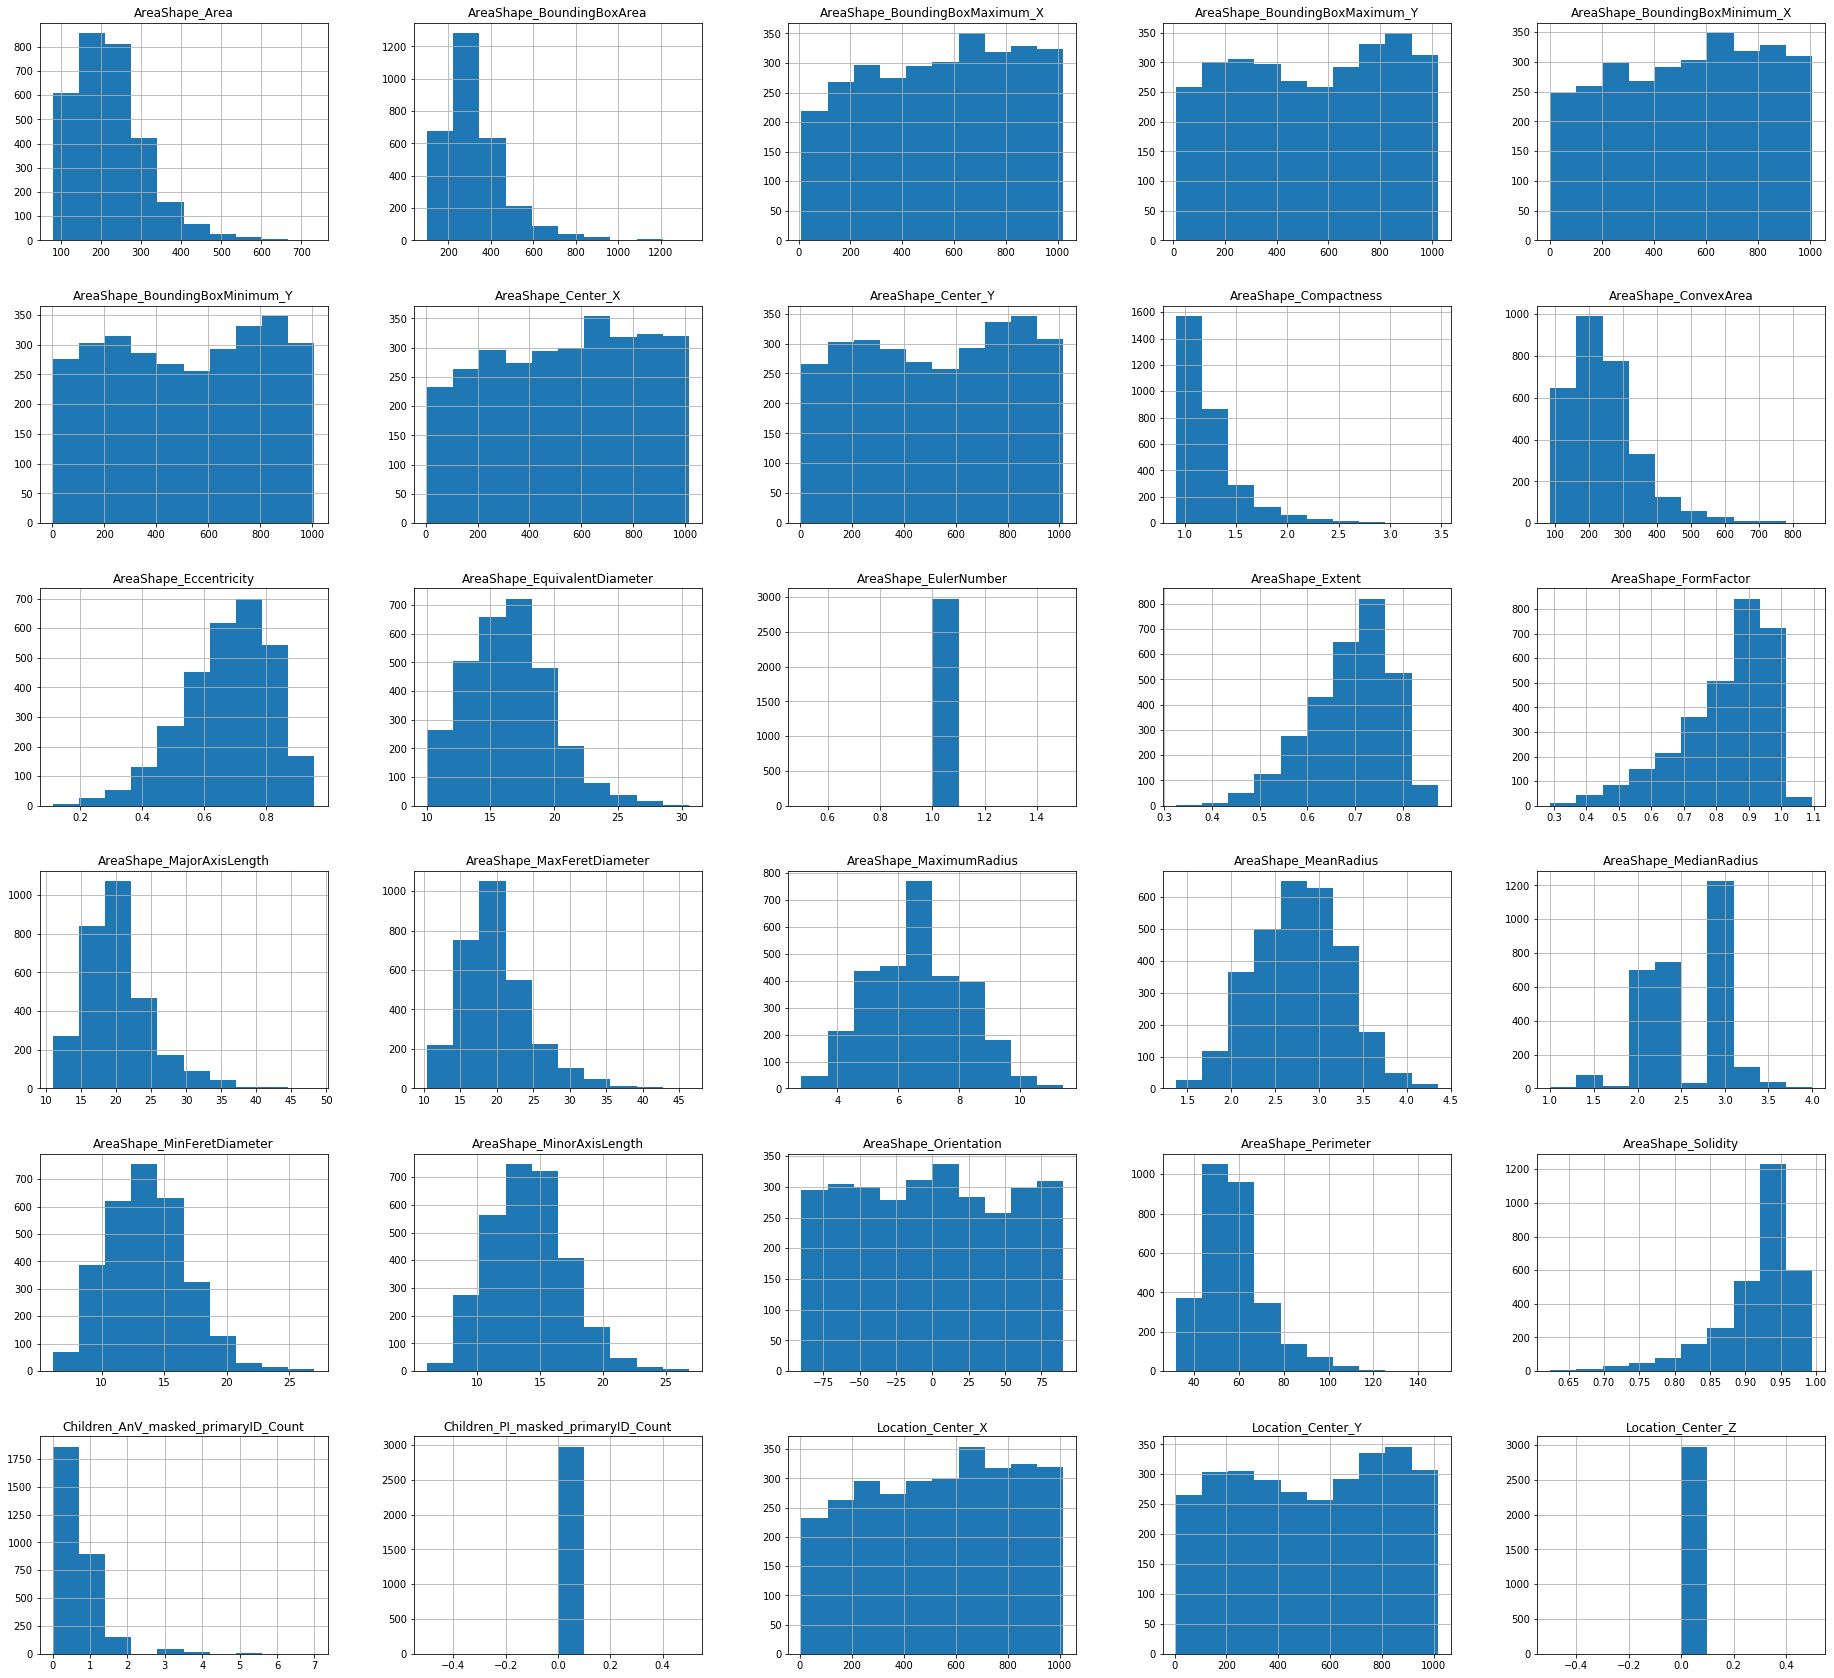

In [57]:
matplotlib.rcParams['figure.figsize'] = (32.0, 30.0)
# Drop few columns
df = Nuclei.drop(['Image', 'ImageNumber', 'Well', 'ObjectNumber', 'Number_Object_Number', 'WellName', 'Field'], axis=1)
df.hist();

### save csv fils to omero@UL server

In [58]:
# check files to be attached back to the plate

def save_results(conn, files, plate):
    # Upload the CSV files
    print("saving results...")
    namespace = "cellprofiler.demo.namespace"
    for f in files:
        ann = conn.createFileAnnfromLocalFile(f, mimetype="text/csv",
                                              ns=namespace, desc=None)
        plate.linkAnnotation(ann)


files_list_con= os.listdir(new_output_directory_concat)
#files_list_con= os.listdir()"/media/rohola/blue1/cloud_drives/surfdrive/data_management/knime_wf/dataset_analyse_MV038/output_jupyter_CP-headless_pipeline-V3")
files_csv_list_con_fullPath= []

for f in files_list_con:
    if f.endswith(".csv"):
        fullPath= os.path.join(new_output_directory_concat, f)
        files_csv_list_con_fullPath.append(fullPath)
for f in files_csv_list_con_fullPath:
    print(f)
print(len(files_csv_list_con_fullPath))
#print(plate.getName)
#print(new_output_directory_concat)
#print(x)

/tmp/tmphfxgidlt/ConCatCSVs/obj_Nuclei_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/obj_AnV_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/Image_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/obj_pi_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/Experiment_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/AnV_masked_primaryID_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/obj_masked_AnV_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/PI_masked_primaryID_concat.csv
/tmp/tmphfxgidlt/ConCatCSVs/obj_masked_pi_concat.csv
9


In [59]:
# attach data to plate in OMERO

def save_results(conn, files, plate):
    # Upload the CSV files
    print("saving results...")
    namespace = "cellprofiler.RH.namespace"
    for f in files:
        ann = conn.createFileAnnfromLocalFile(f, mimetype="text/csv",
                                              ns=namespace, desc=None)
        plate.linkAnnotation(ann)


print(len(files_csv_list_con_fullPath))
save_results(conn, files_csv_list_con_fullPath, plate)
print("Saving to OMERO plate is done!")

9
saving results...
Saving to OMERO plate is done!


### Close the connection to the server

In [60]:
conn.close()